# Analysis of Monthly Mean Hydrologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2018-02-04 22:55:19.627762 by jhamman on r8i0n6


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.tools import dask_distributed_setup
from loca.data_catalog import load_monthly_cmip_hydro_datasets

models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

In [3]:
cluster, client = dask_distributed_setup()
print(cluster) # interact with the cluster object to adjust the size of the computational pool
cluster.scale_up(1)  # TODO: figure out why we need to scale up to 1 worker to open the bcsd/maurer datasets
client

Client Scheduler: tcp://10.148.6.233:48877 Dashboard: http://10.148.6.233:35301/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load Data

In [4]:
hist_data = load_monthly_cmip_hydro_datasets('historical', models=models, autoclose=True)
rcp4_data = load_monthly_cmip_hydro_datasets('rcp45', models=models, autoclose=True)
rcp8_data = load_monthly_cmip_hydro_datasets('rcp85', models=models, autoclose=True)

# TODO: use 1/8th deg LOCA data (waiting on cdo to finish remapping)

load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology


100%|██████████| 6/6 [03:18<00:00, 33.08s/it]


load_monthly_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [05:26<00:00, 54.44s/it]


load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology


100%|██████████| 6/6 [05:31<00:00, 55.28s/it]


load_monthly_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [09:19<00:00, 93.31s/it]


load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology


100%|██████████| 6/6 [05:40<00:00, 56.74s/it]


load_monthly_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [09:35<00:00, 95.88s/it]


In [10]:
cluster.scale_up(5)


[4, 5, 6]

In [15]:
hist_epoch = slice('1979-10-01', '1999-09-30')
futr_epoch = slice('2079-10-01', '2099-09-30')

# TODO: these means should be weighted by days per month
hist_means = dict((k, ds.sel(time=hist_epoch).mean('time').compute()) for (k, ds) in hist_data.items())
rpc4_means = dict((k, ds.sel(time=futr_epoch).mean('time').compute()) for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, ds.sel(time=futr_epoch).mean('time').compute()) for (k, ds) in rcp8_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

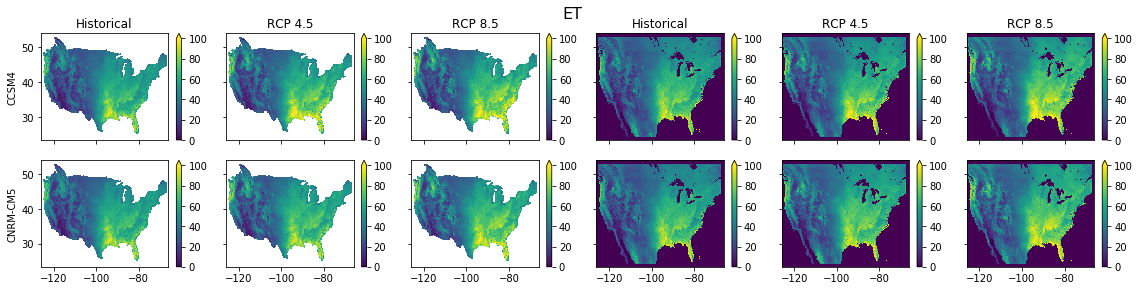

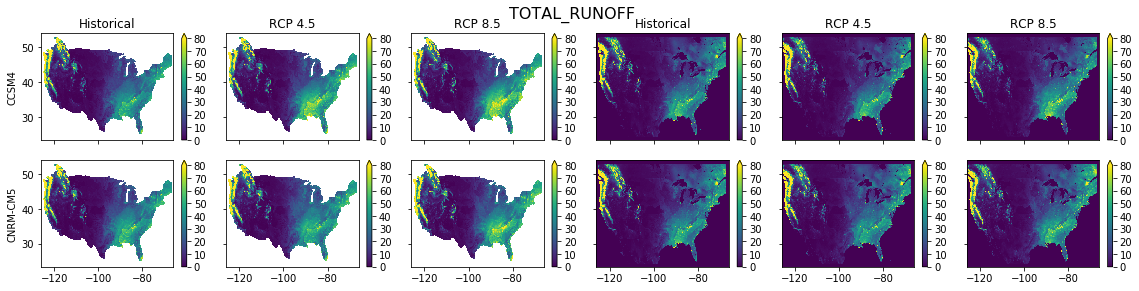

In [21]:
kwargs = {'ET': {'vmin': 0, 'vmax': 100},
          'total_runoff': {'vmin': 0, 'vmax': 80},}

# TODO: Fix mask issue with LOCA

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                
                ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


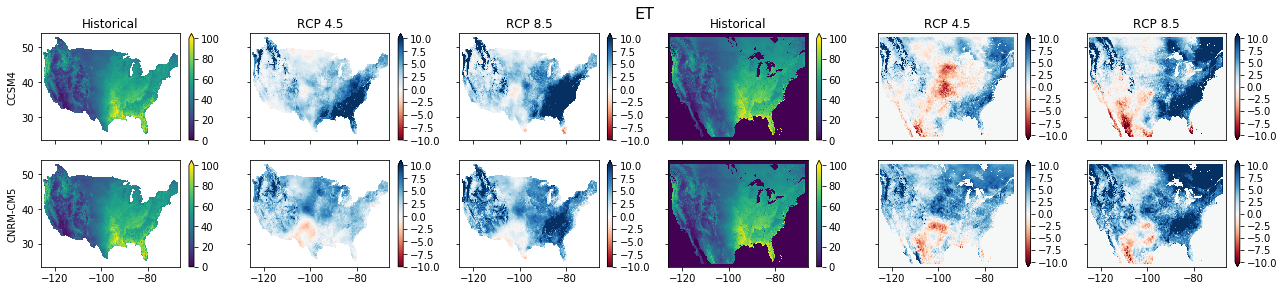

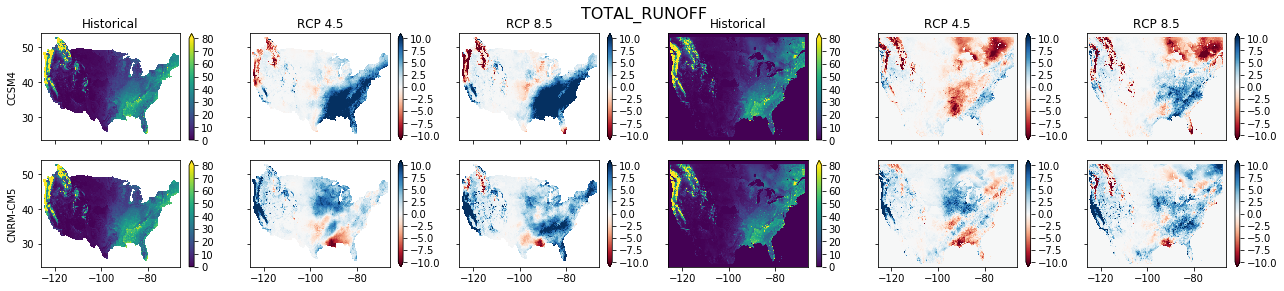

In [24]:
diff_kws = {'ET': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'},
            'total_runoff': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'}}

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
    
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                if 'RCP' in title:
                    (ds_dict[dset][var].sel(gcm=model) - hist_means[dset][var].sel(gcm=model)).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
                else:
                    ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout() 


In [68]:
plt.close('all')